In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import collections as coll
from scipy.optimize import curve_fit


from ont_fast5_api.fast5_interface import get_fast5_file


fs=12 # fontsize
path='/media/storage_3/mb/nanopore_data/analysis/r9.4.1/20200914_1354_6B_PAF27096_e7c9eae6/guppy_v4.0.11_r9.4.1_hac_prom/align_unfiltered/'

def read_fast5(fname, single_or_multi='s'):
    def raw_to_current(rawdata, offset, range, digitisation):
        return list((np.array(rawdata) + offset) * range / digitisation)
    if single_or_multi not in ['s', 'm']:
        raise ValueError('single_or_multi var must be "s" or "m".')
    data = []
    with get_fast5_file(fname, mode="r") as f:
        for read in f.get_reads():
            ch=read.get_channel_info()
            data.append(raw_to_current(read.get_raw_data(), ch['offset'], ch['range'], ch['digitisation']))
    if single_or_multi == 's':
        return np.array(data[0]) # single read --> dim=1
    elif single_or_multi == 'm':
        return np.array(data)


def read_fastq(fname):
    def process(lines=None):
        ks = ['name', 'sequence', 'optional', 'quality']
        return {k: v for k, v in zip(ks, lines)}
    n = 4
    name = []
    seq = []
    with open(fname, 'r') as fq:
        lines = []
        for line in fq:
            lines.append(line.rstrip())
            if len(lines) == n:
                record = process(lines)
                name.append(record['name'][1:37])
                seq.append(record['sequence'])
                lines = []
    return dict(zip(name, seq))


def gauss(x, H, A, mu, sigma):
    'Gauss illesztés'
    return H + A*np.exp(-(x - mu)**2 / (2*sigma**2)) 

---

In [2]:
read_id = '9bf95a6f-6ef4-48bf-81a3-3ea39c510e32'
batch = 7

f5 = read_fast5(path+f'chr22/guppy/workspace/single_read/{batch}/{read_id}.fast5')
print('len(f5) =', len(f5))

c22_fq = read_fastq(path+f"chr22/guppy/pass/fastq_runid_d9de0dacd1438a0d732b5f5f5fdc68d2463a4d6d_{batch}_1.fastq")
print('len(c22_fq[read_id]) =', len(c22_fq[read_id]))

sq_sum = pd.read_csv(path+'chr22/guppy/sequencing_summary.txt', sep='\t')


len(f5) = 37176
len(c22_fq[read_id]) = 3392


H = -25.54 \pm 50.79
A = 2316.31 \pm 79.42
mu = 69.0 \pm 0.43
sigma = -12.35 \pm 0.58


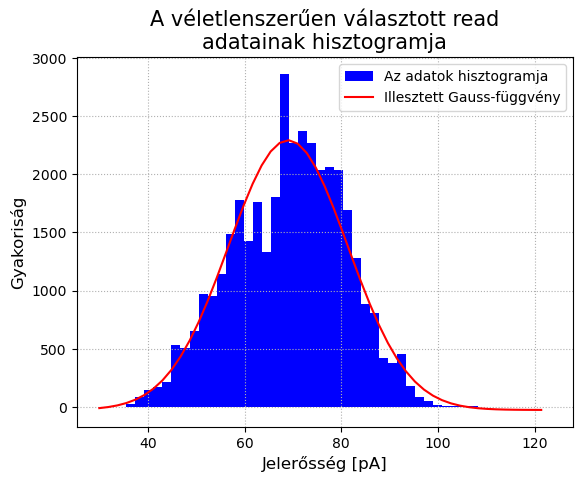

In [3]:
y, x, _ = plt.hist(f5, bins=int(len(set(f5))/4), color='b',  label='Az adatok hisztogramja')

x = x[:-1]
popt, pcov = curve_fit(gauss, x, y, p0=(0,1, 72, 10))
perr = np.sqrt(np.diag(pcov))
plt.plot(x, gauss(x, *popt),  c='r', label="Illesztett Gauss-függvény")


plt.title('A véletlenszerűen választott read\nadatainak hisztogramja', fontsize=fs+3)
plt.xlabel('Jelerősség [pA]', fontsize=fs)
plt.ylabel('Gyakoriság', fontsize=fs)
plt.legend(fontsize=fs-2)
plt.grid(ls='dotted')
plt.savefig('figs/gauss.pdf', bbox_inches='tight')
const_name = ['H', 'A', 'mu', 'sigma']
for i in range(len(const_name)):
    print(f'{const_name[i]} = {np.round(popt[i],2)} \pm {np.round(perr[i],2)}')
plt.show()

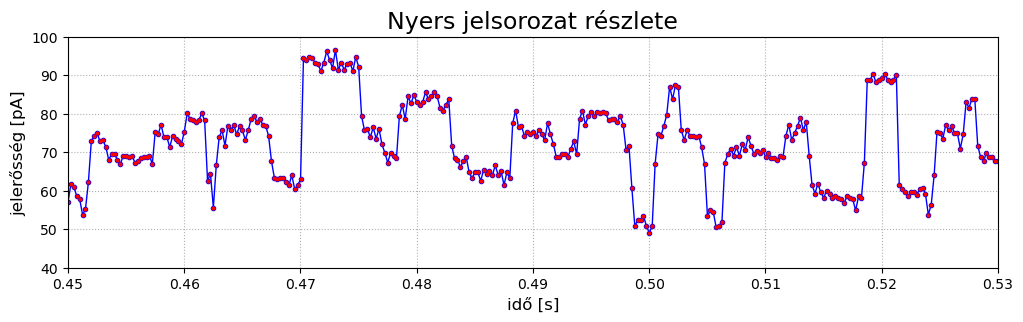

In [4]:
time = np.linspace(0, float(sq_sum[sq_sum['read_id'] == read_id]['duration']), len(f5))

plt.figure(figsize=(12,3))

lower_bound = 0.45
upper_bound = 0.53

plt.plot(time,f5, '-o',c='b', ms=3, lw=1)
plt.plot(time,f5, 'o', c='r', ms=2)

plt.xlim(lower_bound, upper_bound)
plt.ylim(40,100)
plt.title("Nyers jelsorozat részlete", fontsize=fs+5)
plt.xlabel("idő [s]", fontsize=fs)
plt.ylabel("jelerősség [pA]", fontsize=fs)
plt.grid(ls='dotted')
plt.savefig('figs/raw_signal.pdf', bbox_inches='tight')
plt.show()

---

In [5]:
df = pd.read_csv(path+"chr22/nanopolish/read.eventalign.tsv", sep="\t")
df.tail(10)

,contig,position,reference_kmer,read_index,strand,event_index,event_level_mean,event_stdv,event_length,model_kmer,model_mean,model_stdv,standardized_level
7164,gi|568815576|ref|NC_000022.11|,50378184,GTGCCA,0,t,79,101.75,2.023,0.00125,NNNNNN,0.00,0.0,inf
7165,gi|568815576|ref|NC_000022.11|,50378184,GTGCCA,0,t,78,78.17,2.353,0.00175,TGGCAC,81.96,1.9,-1.89
7166,gi|568815576|ref|NC_000022.11|,50378184,GTGCCA,0,t,77,102.23,3.018,0.00100,NNNNNN,0.00,0.0,inf
7167,gi|568815576|ref|NC_000022.11|,50378184,GTGCCA,0,t,76,102.12,2.027,0.00100,NNNNNN,0.00,0.0,inf
7168,gi|568815576|ref|NC_000022.11|,50378184,GTGCCA,0,t,75,105.06,0.751,0.00075,NNNNNN,0.00,0.0,inf
7169,gi|568815576|ref|NC_000022.11|,50378184,GTGCCA,0,t,74,81.24,5.582,0.00100,TGGCAC,81.96,1.9,-0.36
7170,gi|568815576|ref|NC_000022.11|,50378184,GTGCCA,0,t,73,103.21,2.274,0.00175,NNNNNN,0.00,0.0,inf
7171,gi|568815576|ref|NC_000022.11|,50378184,GTGCCA,0,t,72,107.24,0.790,0.00075,NNNNNN,0.00,0.0,inf
7172,gi|568815576|ref|NC_000022.11|,50378184,GTGCCA,0,t,71,104.38,0.931,0.00100,NNNNNN,0.00,0.0,inf
7173,gi|568815576|ref|NC_000022.11|,50378184,GTGCCA,0,t,70,108.06,1.367,0.00075,TGGCAC,81.96,1.9,12.98


In [6]:
kmers_info = np.zeros([len(np.unique(df.position)), 3], dtype='object')
for i, unique in enumerate(np.unique(df.position)):
    kmers_info[i,0] = df[df.position == unique].event_length.sum() # time
    kmers_info[i,1] = df[df.position == unique].event_level_mean.mean() # mean current
    kmers_info[i,2] = list(df[df.position == unique].reference_kmer)[0] # kmer

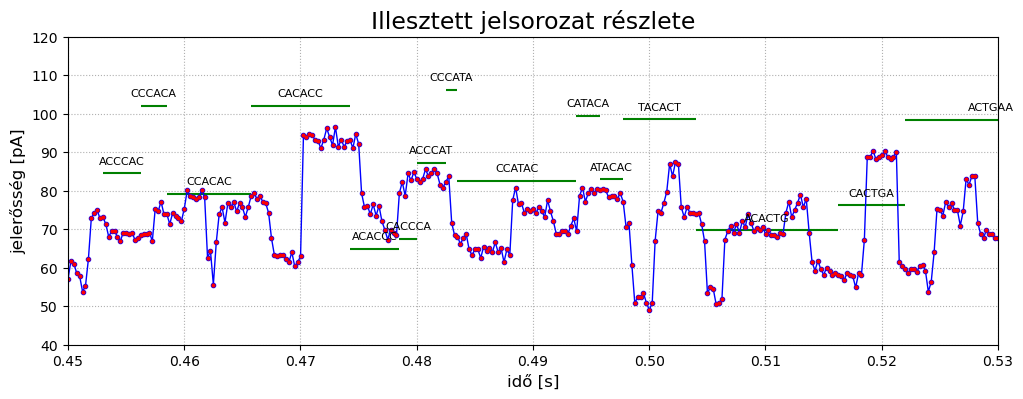

In [7]:
plt.figure(figsize=(12,4))

timelabels = np.cumsum(np.append([0], kmers_info[:,0]) )

#lower_bound = 0.25
#upper_bound = 0.3

text_offset = max(kmers_info[:,1])*0.02
for i in range(len(timelabels)):
    if timelabels[i]>=lower_bound and timelabels[i]<=upper_bound:
        plt.hlines(kmers_info[i,1], timelabels[i], timelabels[i+1], color='green')
        plt.text(np.mean([timelabels[i], timelabels[i+1]]), kmers_info[i,1]+text_offset, kmers_info[i,2], fontsize=8, ha='center')

plt.plot(time,f5, '-o',c='b', ms=3, lw=1)
plt.plot(time,f5, 'o', c='r', ms=2)
plt.xlim(lower_bound, upper_bound)
plt.ylim(40,120) # kell a 120
plt.title("Illesztett jelsorozat részlete", fontsize=fs+5)
plt.xlabel("idő [s]", fontsize=fs)
plt.ylabel("jelerősség [pA]", fontsize=fs)
plt.grid(ls='dotted')
plt.savefig('figs/basecalled_signal_avgcurrent.pdf', bbox_inches='tight')
plt.show()

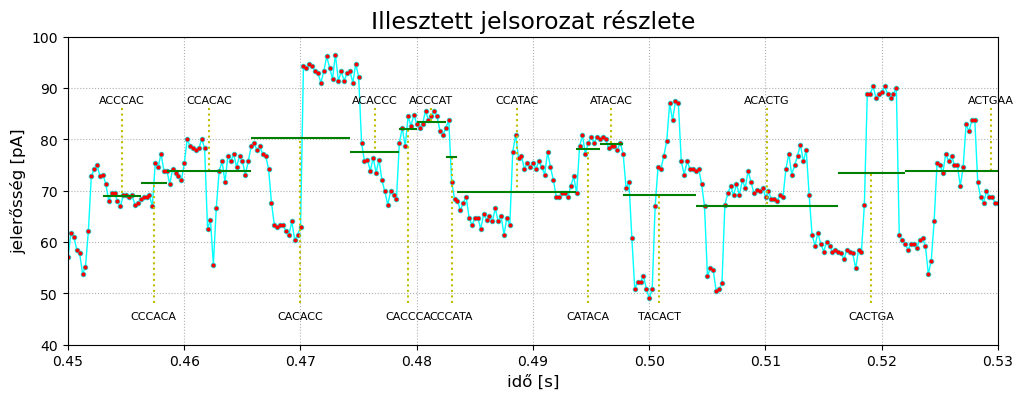

In [8]:
plt.figure(figsize=(12,4))
plt.plot(time,f5, '-o',c='cyan', ms=3, lw=1)
plt.plot(time,f5, 'o', c='r', ms=2)
plt.xlim(lower_bound, upper_bound)
plt.ylim(40,100)

timelabels = np.cumsum(np.append([0], kmers_info[:,0]) )

lower_bound = 0.45
upper_bound = 0.53

text_offset = max(kmers_info[:,1])*0.02
for i in range(len(timelabels)):
    if timelabels[i]>=lower_bound and timelabels[i]<=upper_bound:
        y = np.mean(f5[np.where((time>timelabels[i]) & (time<timelabels[i+1]))])
        y2 = np.mean([timelabels[i], timelabels[i+1]])
        if i%2==0:
            height = 87
            plt.vlines(y2, height-1, y, ls='dotted', color='y')
        else:
            height = 45
            plt.vlines(y2, height+3, y, ls='dotted', color='y')
        plt.hlines(y, timelabels[i], timelabels[i+1], color='green')
        plt.text(y2, height, kmers_info[i,2], fontsize=8, ha='center')
        

plt.title("Illesztett jelsorozat részlete", fontsize=fs+5)
plt.xlabel("idő [s]", fontsize=fs)
plt.ylabel("jelerősség [pA]", fontsize=fs)
plt.grid(ls='dotted')
plt.savefig('figs/basecalled_signal_wo_avgcurrent.pdf', bbox_inches='tight')
plt.show()

---

In [9]:
fq_counts = coll.Counter({'A':0, 'T':0, 'G':0, 'C':0})

whole_c22_fq = read_fastq(path+'chr22/guppy/pass_cat/chr22.fastq')

for key in whole_c22_fq:
    fq_counts += coll.Counter([*whole_c22_fq[key]])

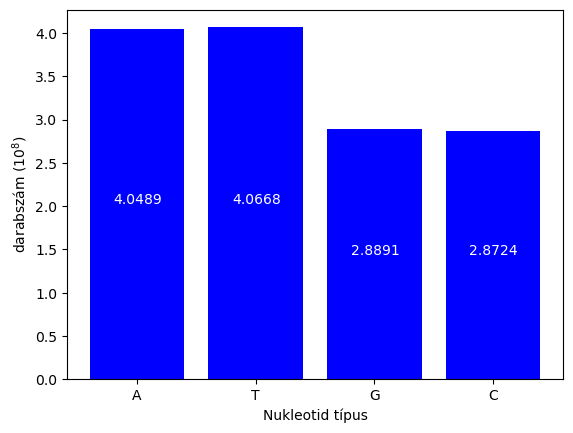

In [10]:
fq_counts_val = np.array(list(fq_counts.values()))/1e8
plt.bar(fq_counts.keys(), fq_counts_val, color='b')
for i, v in enumerate(fq_counts_val):
    plt.text(i-0.2, v/2, str(round(v,4)), color='white')

plt.xlabel('Nukleotid típus', fontsize=fs-2)
plt.ylabel('darabszám ($10^8$)', fontsize=fs-2)
plt.savefig('figs/nuc_distr_chr22.pdf', bbox_inches='tight')
plt.show()